<a href="https://colab.research.google.com/github/Zagreus98/PAIC_laborator/blob/main/Lab3_TACAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd drive/MyDrive/TACAI/
!pwd

/content/drive/MyDrive/TACAI
/content/drive/MyDrive/TACAI


In [1]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
base_path =  '/content/drive/MyDrive/TACAI/'

img_path_by_class = []
for i in range(4):
  c_p = base_path + str(i) + "/*.jpg"
  img_path_by_class.append(glob.glob(c_p))



In [3]:
img_path_by_class = np.array(img_path_by_class)
print(img_path_by_class.shape)
np.random.seed(42)
for path in img_path_by_class:
  np.random.shuffle(path)


(4, 10)


In [8]:
# Salvam si labels
labels = []
for class_path in img_path_by_class:
  tmp = []
  for img_path in class_path:
    label = img_path.split('/')[5]
    tmp.append(label)
  labels.append(tmp)

labels=np.array(labels)
labels

array([['0', '0', '0', '0', '0', '0', '0', '0', '0', '0'],
       ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1'],
       ['2', '2', '2', '2', '2', '2', '2', '2', '2', '2'],
       ['3', '3', '3', '3', '3', '3', '3', '3', '3', '3']], dtype='<U1')

In [9]:
# CITIRE IMAGINI si impartire in train/test
train_paths = img_path_by_class[:,:7]
y_train = labels[:,:7]
test_paths = img_path_by_class[:,7:]
y_test = labels[:,7:]

train_imgs = []
test_imgs = []


for i in range(train_paths.shape[0]):
  tmp = []
  for j in range(train_paths.shape[1]):
    img = cv2.imread(train_paths[i][j])
    tmp.append(img)
  train_imgs.append(tmp)

for i in range(test_paths.shape[0]):
  tmp = []
  for j in range(test_paths.shape[1]):
    img = cv2.imread(test_paths[i][j])
    tmp.append(img)
  test_imgs.append(tmp)

print(train_imgs[0][0].shape)


(4032, 1908, 3)


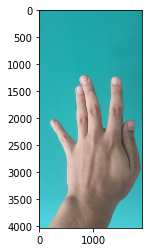

In [ ]:
plt.figure()
plt.imshow(train_imgs[0][0][...,::-1])

In [11]:
def condition(image):
    img = image.copy()
    R,G,B = np.split(img[...,::-1],indices_or_sections=3, axis=2)
    C1 = (R> 95) & (G>40) & (B>20) # nuantele generale de piele
    # compoenentele r,g,b nu trebuie sa fie prea aproape unul de altul => eliminam griurile
    C2 = ((np.vstack([R,G,B]).max(axis=0) - np.vstack([R,G,B]).min(axis=0) > 15))
    # componentele rosu si verde sa nu fie prea apropiate intre ele
    C3 = (np.abs(R-G) > 15)
    # cea mai puternica nuanta trebuie sa fie rosu fiind piele
    C4 = (R>G)&(R>B)

    # restul sunt conditii de iluminant
    C5 = (R>220) & (G>210) & (B>170)
    C6 = (np.abs(R-G) <= 15)
    C7 = (R>B) & (G>B)
    # combinam toate conditiile
    cond1 = (C1 * C2 * C3 * C4) + (C4 * C5 * C6 * C7)
    cond1[cond1 > 1] = 1 # vrem ca 1+1 sa dea 1 nu 2
    # facem squeeze sa scapam de ultima dimensiune de 1
    return cond1.squeeze(axis=2)

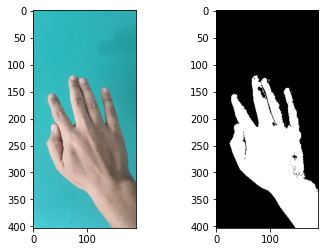

In [ ]:

mask = condition(train_imgs[0][1])
# nucleu = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
# mask = cv2.morphologyEx(mask.astype(np.float32), cv2.MORPH_CLOSE, nucleu,iterations=2)
plt.figure()
plt.subplot(121);plt.imshow(train_imgs[0][1][...,::-1])
plt.subplot(122);plt.imshow(mask,cmap='gray')

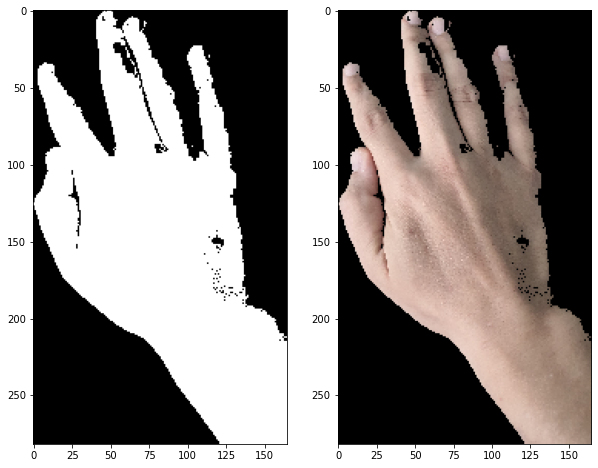

In [ ]:
# gasim punctele din imagine care definesc conturul mainii
contours, hierarchy = cv2.findContours(mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
img_copy = train_imgs[0][1].copy()[...,::-1]
# cv2.drawContours(img_copy, contours[3], -1, (0,255,0), 3)
# plt.figure(figsize=(10,20))
# plt.imshow(img_copy)


# bazandu-ne pe contururi cautam bounding box-ul cu cea mai mare arie
dreptunghi = None
maxArea = 0
indice = 0
for i,cont in enumerate(contours):
  tmp = cv2.boundingRect(cont)
  if maxArea < tmp[2] * tmp[3]:
    maxArea = tmp[2] * tmp[3]
    dreptunghi = tmp
    indice = i

dr = dreptunghi
cv2.rectangle(img_copy,(dr[0],dr[1]),(dr[0]+dr[2],dr[1]+dr[3]),(0,255,0),2)

img_copy = img_copy[dreptunghi[1]:dreptunghi[1]+dreptunghi[3],dreptunghi[0]:dreptunghi[0] + dreptunghi[2]]
mask = mask[dreptunghi[1]:dreptunghi[1]+dreptunghi[3],dreptunghi[0]:dreptunghi[0] + dreptunghi[2]]

img_copy[mask==0] = 0

plt.figure(figsize=(10,20))
plt.subplot(121);plt.imshow(mask,cmap='gray')
plt.subplot(122);plt.imshow(img_copy,cmap='gray')




(9360, 1)


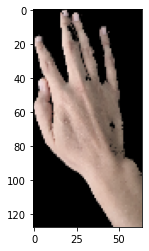

In [ ]:
height = 128
width = 64
img_copy = cv2.resize(img_copy,(width,height))
plt.figure()
plt.imshow(img_copy)

winSize = (32,32) # is the size of the image cropped to an multiple of the cell size
blockSize = (32,32) #dimensiunea blocului de celule, i.e numarul de celule
blockStride = (8,8) # stride-ul cu care se misca blocul de celule
cellSize = (8,8) # dimensiunea unei celule din imagine
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection,nlevels)

descriptor = hog.compute(img_copy)


**Acum ca am hotarat implementarea punem totul in functii**

In [12]:
def segmentare_imagine(img):
  img_copy = img.copy()
  mask = condition(img)
  # cautam mai multe contururi in imagine
  contours, hierarchy = cv2.findContours(mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  # bazandu-ne pe contururi cautam bounding box-ul cu cea mai mare arie
  dreptunghi = None
  maxArea = 0
  indice = 0
  for i,cont in enumerate(contours):
    tmp = cv2.boundingRect(cont)
    if maxArea < tmp[2] * tmp[3]:
      maxArea = tmp[2] * tmp[3]
      dreptunghi = tmp
      indice = i

  dr = dreptunghi
  cv2.rectangle(img_copy,(dr[0],dr[1]),(dr[0]+dr[2],dr[1]+dr[3]),(0,255,0),2)

  # redimensionare imagine dupa bbox gasit
  img_copy = img_copy[dreptunghi[1]:dreptunghi[1]+dreptunghi[3],dreptunghi[0]:dreptunghi[0] + dreptunghi[2]]
  mask = mask[dreptunghi[1]:dreptunghi[1]+dreptunghi[3],dreptunghi[0]:dreptunghi[0] + dreptunghi[2]]
  # segmentarea propriu zisa
  img_copy[mask==0] = 0


  return img_copy

In [40]:
#TODO: incearca sa reduci dimensiunea descriptorilor pentru acuratete mai mare
# si fa un shuffle cum trebuia facut la date pentru SVM
# Definire HOG
winSize = (32,32) # is the size of the image cropped to an multiple of the cell size
blockSize = (32,32) #dimensiunea blocului de celule, i.e numarul de celule
blockStride = (8,8) # stride-ul cu care se misca blocul de celule
cellSize = (8,8) # dimensiunea unei celule din imagine
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection,nlevels)

def extract_descriptor(img,height=128,width=64):
  img_copy = img.copy()
  img_copy = cv2.resize(img_copy,(width,height))
  descriptor = hog.compute(img_copy) 
  return descriptor

In [78]:
# Alicam segmentare + HOG pe toate imaginile din setul de date 
train_descr = []
test_descr = []
for img_class in train_imgs:
  tmp = []
  for img in img_class:
    img_sgm = segmentare_imagine(img)
    descriptor = extract_descriptor(img_sgm)
    tmp.append(descriptor)
  train_descr.append(tmp)    

In [79]:
for img_class in test_imgs:
  tmp = []
  for img in img_class:
    img_sgm = segmentare_imagine(img)
    descriptor = extract_descriptor(img_sgm)
    tmp.append(descriptor)
  test_descr.append(tmp)

In [68]:
train_descr = np.array(train_descr)
y_train = y_train.reshape(-1)
train_descr = train_descr.reshape(28,-1)
print(train_descr.shape)
print(y_train.shape)



(28, 9360)
(28,)


In [47]:
###### KNN
knn = cv2.ml.KNearest_create()
knn.train(train_descr,cv2.ml.ROW_SAMPLE,y_train)

True

In [98]:
## Testare KNN
contor = 0
for i,desc_class in enumerate(test_descr):
  for descr in desc_class:
    descr = np.array(descr).astype(np.float32)
    descr = descr.reshape(1,-1)
    label,_,_,_ = knn.findNearest(descr,k=3)
    print('prezis',label)
    print('ground truth',i)
    if i==label:
      contor+=1

print( f'Acuratete: {100 * contor / (len(test_descr)*len(test_descr[0]))}%')



prezis 0.0
ground truth 0
prezis 0.0
ground truth 0
prezis 0.0
ground truth 0
prezis 1.0
ground truth 1
prezis 3.0
ground truth 1
prezis 1.0
ground truth 1
prezis 2.0
ground truth 2
prezis 2.0
ground truth 2
prezis 0.0
ground truth 2
prezis 3.0
ground truth 3
prezis 3.0
ground truth 3
prezis 3.0
ground truth 3
Acuratete: 83.33333333333333%


In [96]:
## SUPPORT VECTOR MACHINE
import copy 
train_descr_copy = copy.deepcopy(train_descr)
y_train_copy = copy.deepcopy(y_train)

train_descr_copy = np.array(train_descr_copy).astype(np.float32)
y_train_copy = y_train_copy.reshape(-1).astype(np.int32)
train_descr_copy = train_descr_copy.reshape(28,-1)

svm = cv2.ml.SVM_create()
svm.setType(cv2.ml.SVM_C_SVC)
svm.setKernel(cv2.ml.SVM_POLY)
svm.setDegree(2)
svm.train(train_descr_copy,cv2.ml.ROW_SAMPLE,y_train_copy)


True

In [99]:
## Testare SVM
contor = 0
for i,desc_class in enumerate(test_descr):
  for descr in desc_class:
    descr = np.array(descr).astype(np.float32)
    descr = descr.reshape(1,-1)
    label = svm.predict(descr)[1][0][0]
    print('prezis',label)
    print('ground truth',i)
    if i==label:
      contor+=1

print( 100* contor / (len(test_descr)*len(test_descr[0])))

prezis 0.0
ground truth 0
prezis 1.0
ground truth 0
prezis 0.0
ground truth 0
prezis 1.0
ground truth 1
prezis 3.0
ground truth 1
prezis 2.0
ground truth 1
prezis 2.0
ground truth 2
prezis 2.0
ground truth 2
prezis 2.0
ground truth 2
prezis 3.0
ground truth 3
prezis 3.0
ground truth 3
prezis 3.0
ground truth 3
75.0
